In [1]:
import pandas as pd
from functions import get_file
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import lemminflect

In [4]:
reviews = get_file('tables/reviews_pennsylvania.csv')

Loading file...
File loaded...


In [ ]:
nlp = spacy.load('en_core_web_md')
nlp.add_pipe('spacytextblob')

def check_polarity(text):
    doc = nlp(text)
    return doc._.blob.polarity

reviews['polarity'] = reviews['text'][:10000].apply(lambda x: check_polarity(x))

In [ ]:
with open('tables/reviews_polarity.csv', 'w') as f:
    reviews[:10000].to_csv(f, header=True, index=False)

#### Correlation between polarity and star ratings

In [6]:
reviews = get_file('tables/reviews_polarity.csv')

Loading file...
File loaded...


In [10]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,polarity
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,0.085278
1,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,0.302557
2,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,0.202778
3,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16,0.505556
4,8JFGBuHMoiNDyfcxuWNtrA,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14,0.384000


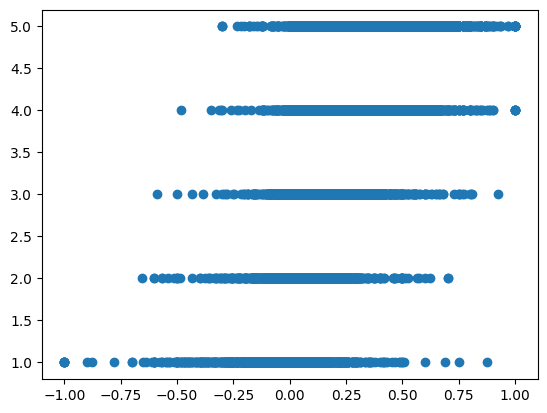

In [11]:
import matplotlib.pyplot as plt

plt.scatter(reviews['polarity'], reviews['stars'])
plt.show()

### Analys negative reviews

#### We want to find statements about food

In [2]:
reviews = get_file('tables/reviews_polarity.csv')

Loading file...
File loaded...


In [72]:
# Training the entity rule to recognize food

food = pd.read_csv('food_labels/food.csv')

In [89]:
food_labels = food[food['description'].str.contains('[a-zA-Z]') == True]['description']

In [90]:
food_labels = food_labels[food_labels.str.split().apply(len) <= 2].drop_duplicates()

In [91]:
food_labels = food_labels.str.lower()

In [92]:
food_labels = food_labels[food_labels.str.contains('.*,.*,.*', regex=True) == False]

In [93]:
# Fix: Foods are comma seperated and order is reversed: 'muffins, blueberry' become 'blueberry muffins'

food_labels[food_labels.str.contains(', ') == True] = (
    food_labels[food_labels.str.contains(', ') == True].str.split(', ', expand=True)[1] +
    ' ' +
    food_labels[food_labels.str.contains(', ') == True].str.split(', ', expand=True)[0]
)

food_labels[food_labels.str.contains(',') == True] = (
    food_labels[food_labels.str.contains(',') == True].str.split(',', expand=True)[1] +
    ' ' +
    food_labels[food_labels.str.contains(',') == True].str.split(',', expand=True)[0]
)

In [94]:
# If label has no plural, create singular form. If label has no singular, create plural 

nlp = spacy.load('en_core_web_lg')

inflected_labels = []

for label in food_labels:
    
    doc = nlp(label)

    if len(doc) == 1:
        if doc[0].tag_ == 'NNS':
            inflected_labels.append(doc[0]._.inflect('NN'))
        else:
            inflected_labels.append(doc[0]._.inflect('NNS'))

    if len(doc) == 2:
        if doc[1].tag_ == 'NNS':
            inflected_labels.append(doc[0].text + ' ' + doc[1]._.inflect('NN'))
        else:
            inflected_labels.append(doc[0].text + ' ' + doc[1]._.inflect('NNS'))

In [99]:
food_labels_inflected = pd.Series(inflected_labels)

In [100]:
food_labels = pd.concat([food_labels, food_labels_inflected])

In [101]:
food_labels.drop_duplicates(inplace=True)

In [103]:
# Add food labels to entity ruler

food_labels = food_labels  # Remove 'bar' from foods_labels, add 'product'

patterns = []

nlp = spacy.load('en_core_web_lg')

ruler = nlp.add_pipe('entity_ruler', before='ner')

for label in food_labels:
    patterns.append({'label': 'FOOD', 'pattern': label})

ruler.add_patterns(patterns)

In [104]:
len(patterns)

30704

In [106]:
ruler.to_disk('food_labels/food_patterns.jsonl')

In [3]:
nlp = spacy.load('en_core_web_lg')

ruler = nlp.add_pipe("entity_ruler", before='ner')

ruler.from_disk('food_labels/food_patterns.jsonl')

#### Look for word patterns

In [20]:
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)

matcher.add(
    'IS_ADJECTIVE',
    [
        [
            {'ENT_TYPE': 'FOOD'},
            {'LEMMA': {'IN': ['be', 'taste', 'smell']}},
            {'DEP': 'neg', 'OP': '?'},
            {'POS': 'ADV', 'OP': '?'},
            {'POS': 'ADJ'}
        ]
    ],
    greedy='LONGEST'
)

def find_food_statements(text):
    doc = nlp(text)
    matches = matcher(doc)

    food_statements = []
    for _, start, end in matches:
        food_statements.append(doc[start: end].text)

    if food_statements != []:
        return ', '.join(food_statements)
    
reviews['food_reviews'] = reviews['text'][:1000].apply(lambda x: find_food_statements(x))

In [21]:
reviews

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,polarity,food_reviews
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,0.085278,food is good
1,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,0.302557,None
2,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,0.202778,None
3,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16,0.505556,None
4,8JFGBuHMoiNDyfcxuWNtrA,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14,0.384000,appetizer was very good
...,...,...,...,...,...,...,...,...,...,...,...
9995,NmYlzT74T1u3Lu_e_NfN6A,48hz4yK6WgW3Qj_XGLi2dQ,nQTJn9kdpU9Mns-b_qduVw,3,0,0,0,I was at the barbary the other evening for a D...,2015-09-25 15:36:04,-0.055401,NaN
9996,bDdj-j1jy9i0k_SV26kj6g,4ejlbjHaw_3ENERTn0llMw,9gObo5ltOMo6UgsaXaHPWA,3,1,0,1,I only came here for drinks while walking arou...,2012-10-11 13:30:12,0.358333,NaN
9997,AVaaUs4MtAwKmK6JK1fVNA,ytOtCnpjsu8yK8uipLqfeA,J-ciDDEdIHMcChGIyKZnOg,3,0,0,0,Hmm.. Definitely one of those places that does...,2017-02-11 02:36:06,0.032670,NaN
9998,cHfjuarZTZhIctrRdSPDHQ,oiZS6XIRlG6CW1erIUq1eg,i221dg3tgAMZLG-zeS5k3g,5,0,0,0,This is my favorite place to get froyo in my a...,2017-06-29 18:47:12,0.364754,NaN
